###### Inicialização

In [9]:
!pip install meteostat yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [10]:
import numpy as np
import pandas as pd
from datetime import datetime, date
from IPython.display import Markdown

from scipy import stats
import statsmodels.api as sm
from statsmodels.graphics import tsaplots as tsa
from statsmodels.tsa.stattools import adfuller

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (22,6)

from meteostat import Point, Daily

from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override()

In [11]:
SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 24

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams["figure.figsize"] = (22,6)

In [12]:
def resultado_adf(resultado, alpha = .05):
  adf, pvalue, usedlag, nobs, critical = resultado[0:5]
  
  display(Markdown('Statistics=%.3f, p-valor=%.8f' % (adf, pvalue)))
  # interpretando resultados
  if pvalue > alpha:
      display(Markdown("**A série não é estacionária (falhamos em rejeitar H0)**"))
  else:
      display(Markdown('**A série é estacionária (rejeitamos H0)**'))

# Análise de Séries temporais (Sessão 10)
---
Modelando Séries (parte 1)

## Modelagem de Séries Temporais

## Caminho Aleatório

É um modelo onde a localização no tempo presente $t$ é a soma da localização anterior e do ruído $𝜀$ . Aqui, assumimos que o ruído é normalmente distribuído (média de 0 e variância de 1). E é espresso pela sequinte fórmula:

\begin{align}
X_t = X_{t-1} + 𝜀_t
\end{align}

Assim como, podemos expressar cada momento no tempo com a seguinte fórmula:

\begin{align}
X_t = \sum_{i=1}^t{𝜀_i}
\end{align}

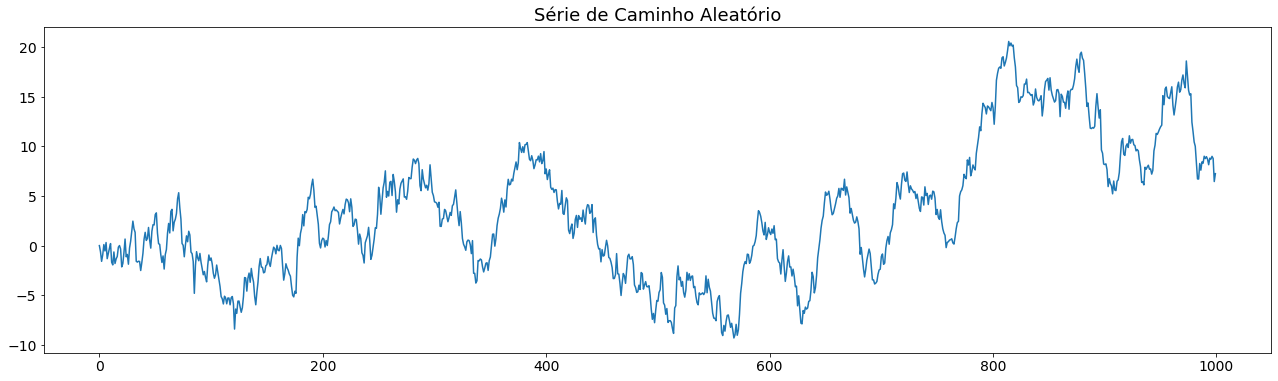

In [14]:
steps = np.random.standard_normal(1000)
steps[0] = 0

random_walk = pd.Series(steps).cumsum()

_ = random_walk.plot(title="Série de Caminho Aleatório")

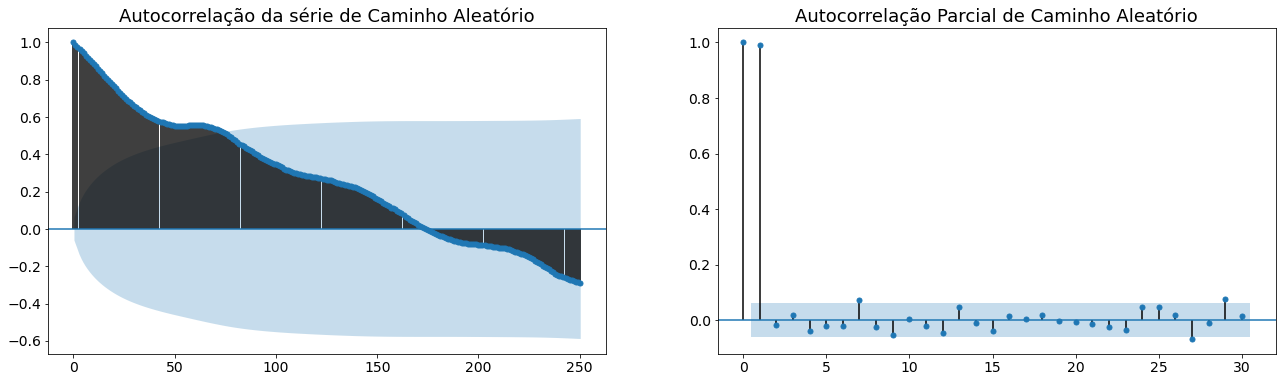

In [15]:
fig, axs = plt.subplots(1,2)
tsa.plot_acf(random_walk, ax = axs[0], lags = len(random_walk) / 4,  title="Autocorrelação da série de Caminho Aleatório")
_ = tsa.plot_pacf(random_walk, ax = axs[1], title="Autocorrelação Parcial de Caminho Aleatório")

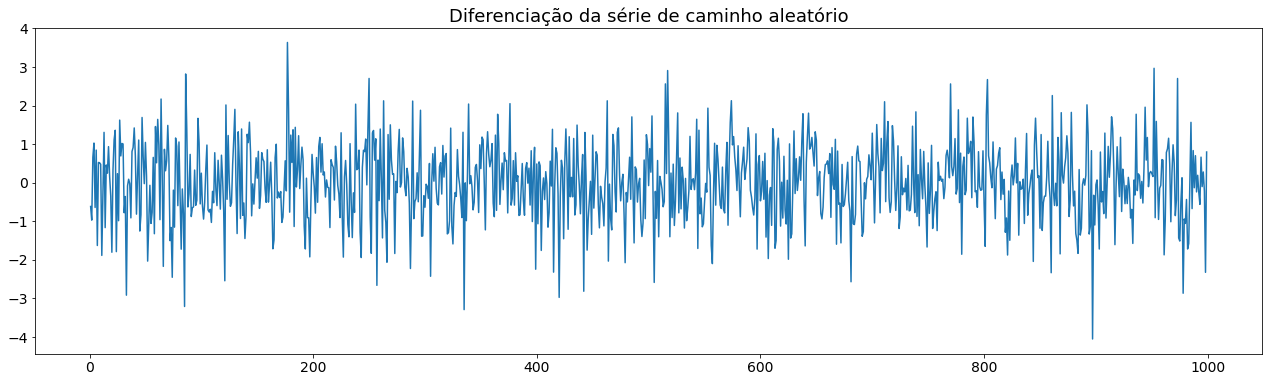

In [16]:
_ = random_walk.diff().plot(title="Diferenciação da série de caminho aleatório")

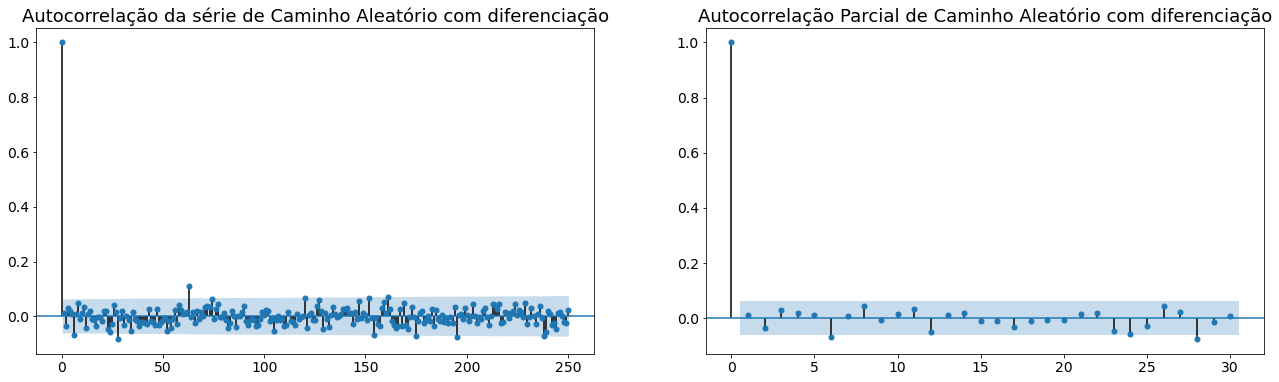

In [17]:
fig, axs = plt.subplots(1,2)
tsa.plot_acf(random_walk.diff()[1:], ax = axs[0], lags = len(random_walk.diff()) /4, title="Autocorrelação da série de Caminho Aleatório com diferenciação")
_ = tsa.plot_pacf(random_walk.diff()[1:], ax = axs[1], title="Autocorrelação Parcial de Caminho Aleatório com diferenciação")

Nota:
- A função inversa da diferenciação é a soma acumulada.

## Ruído Branco

Uma série de ruído branco é importante porque ela normalmente surge como uma série residual (ε), depois que um modelo da série temporal estacionária [f(∙)] é ajustado
$X_t = f(\cdot) + 𝛆$

Em que $X_t$ é uma série temporal estacionária.



**Definição**

Uma série temporal $(ε_1, ε_2, ..., ε_n)$ é considerada um ruído branco, se as variáveis aleatórias $ε_1, ε_2,$ ... são **independentes e identicamente distribuídas (iid)** com média zero, que implica que:

- Todas as variáveis aleatórias $ε_t$ possuem a mesma variância
- Não há autocorrelação ou autocorrelação parcial significativa para qualquer passo h.
- Todas as frequências estão em mesma proporção

Caso as variáveis aleatórias $ε_1, ε_2$, ... também sigam uma distribuição Normal ou Gaussiana, i.e. εt ≈ N(0, σ2), a série é chamada de ruído branco gaussiano.

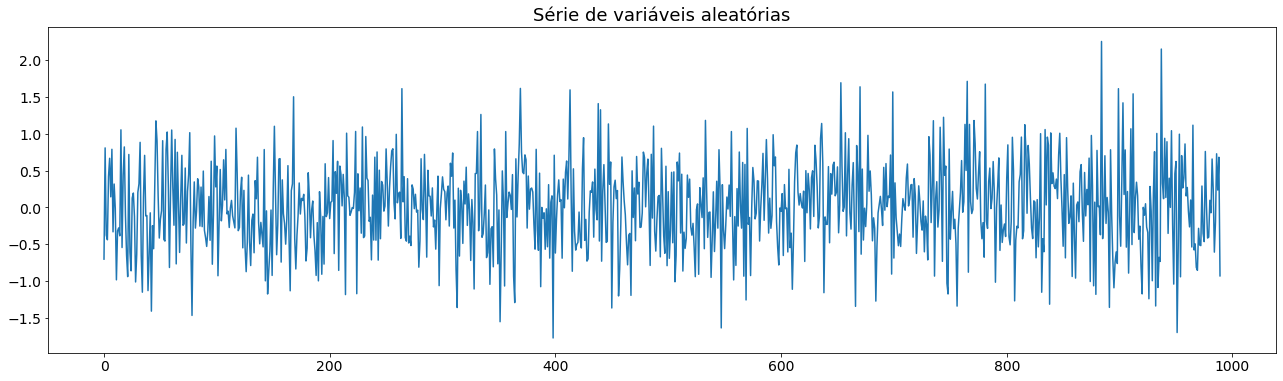

In [18]:
x = np.arange(1, 100, 0.1)

mu = 0
sigma = .6
R =  pd.Series(np.random.randn(len(x)) * sigma + mu)
_ = R.plot(kind='line', title="Série de variáveis aleatórias")

## Teste de Estacionariedade

Uma maneira de testar se uma série temporal é estacionária é realizar um **teste Dickey-Fuller aumentado**, que usa as seguintes hipóteses nula e alternativa:

- $H_0$ (hipótese nula): A série temporal é não estacionária. Em outras palavras, possui alguma estrutura dependente do tempo e não possui variação constante ao longo do tempo.

- $H_1$  (hipótese Alternativa): A série temporal é estacionária.

A estatística de Dickey-Fuller Aumentado (ADF), usada no teste, é um número negativo. Quanto mais negativo for, mais forte será a rejeição da hipótese de que existe uma raiz unitária em algum nível de confiança.

In [19]:
resultado_adf(adfuller(random_walk))

Statistics=-2.351, p-valor=0.15598340

**A série não é estacionária (falhamos em rejeitar H0)**

In [23]:
resultado_adf(adfuller(random_walk.diff()[1:]))

Statistics=-31.198, p-valor=0.00000000

**A série é estacionária (rejeitamos H0)**

In [20]:
resultado_adf(adfuller(R))

Statistics=-33.079, p-valor=0.00000000

**A série é estacionária (rejeitamos H0)**

## Modelos Auto Regressivos (AR)

A formulação mais natural de um modelo de séries temporais estacionáriasé uma regressão linear dos valores passadosda própria série.

É a origem do termo Autoregressivo. Os modelos autoregressivos são muito práticos e são a forma mais popular de descrever séries temporais.

**Definição**

Um modelo autoregressivo de ordem p, AR(p) é baseado na combinação linear das observações passadas:

\begin{align}
x_t = α_1 x_{t-1} + α_2 x_{t-2} + ... α_p x_{t-p} + ε_t
\end{align}

Em que, o termo de pertubação $ε_t$ vem de um processo de ruído branco (iid), sendo também (estocasticamente) independente de $x_{t-1}, x_{t-2}...$ . Assim, $ε_t$ pode ter o poder de "comandar" a série em uma nova direção.


#### Simulando um processo AR(1)
Usaremos a equação $X_t = 9 + 0.7 \cdot X_{t-1} + ε_t$

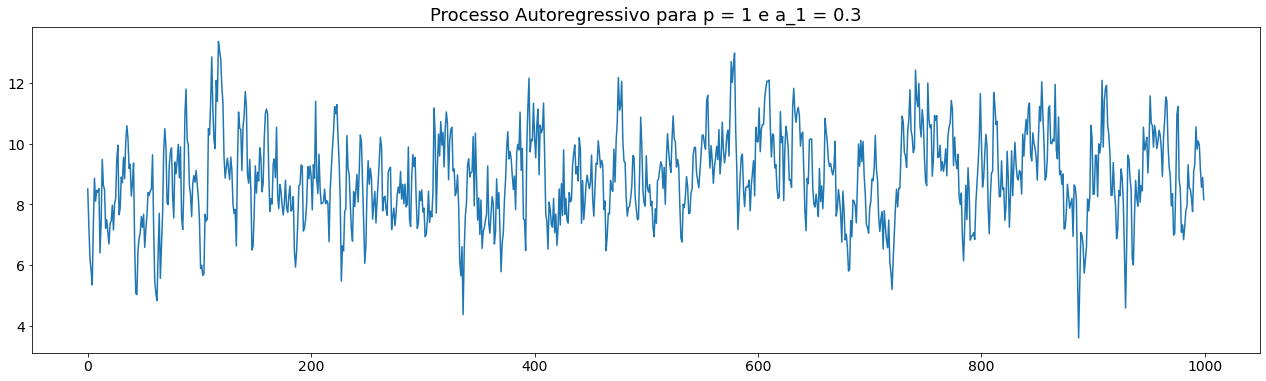

In [24]:
ar = np.array([1, -0.7])
ma = np.array([1])

serie_ar1 = sm.tsa.ArmaProcess(ar, ma).generate_sample(nsample=1000)
serie_ar1 = pd.Series(serie_ar1) + 9

_ = serie_ar1.plot(title = "Processo Autoregressivo para p = 1 e a_1 = 0.3")

#### Simulando processos AR(2)
Usaremos a equação $X_t = 0.3 \cdot X_{t-1} + 0.5 \cdot X_{t-2} + ε_t$

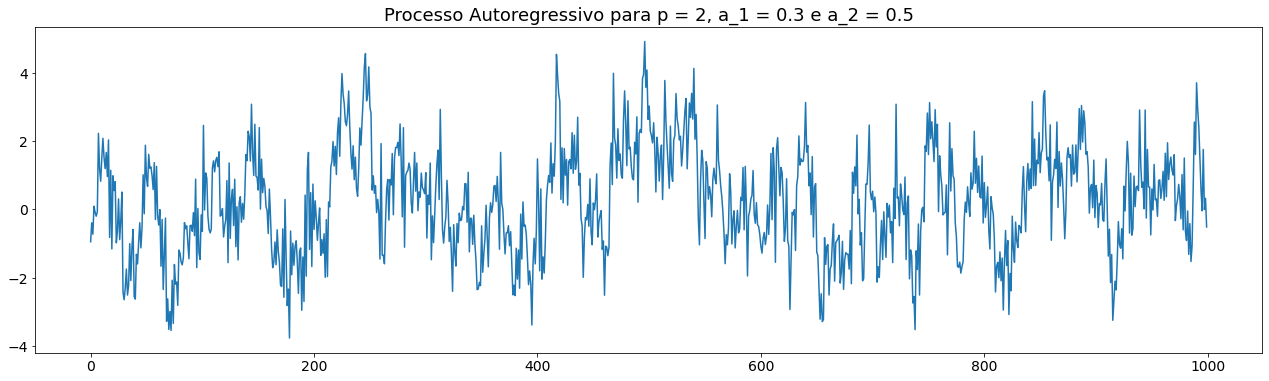

In [25]:
ar = np.array([1, -.3, -.5])
ma = np.array([1])

serie_ar2 = sm.tsa.ArmaProcess(ar, ma).generate_sample(nsample=1000)
serie_ar2 = pd.Series(serie_ar2)

_ = serie_ar2.plot(title = "Processo Autoregressivo para p = 2, a_1 = 0.3 e a_2 = 0.5")

**Atenção**: Modelos de AR(p) devem ser ajustados apenas para séries temporais estacionárias, i.e. qualquer tendência e efeitos sazonais potenciais precisam ser primeiramente removidos. Precisamos também certificar que o processo AR(p) é estacionário, ou seja:
- Possui média global zero;
- $σ_X^2 = \frac{σ_E^2}{1-\alpha_1^2}$ para um processo AR(1);
- AR(1) só pode ser estacionário se $|\alpha_1| < 1$. Entretanto, a dependência da série com o passado não pode ser muito elevado ($|\alpha_1|$ próximo de 1), pois a memória simplesmente desaparece... . Se $|\alpha_1|$, o processo diverge.
- As raízes do polinômio característico devem ser maiores que 1 em valores absolutos para que AR(p) seja considerado um processo estacionário.

A maioria das séries temporais possuem uma média global diferente de zero. Neste caso, defini-se o seguinte processo:

\begin{align}
Y_t = m + X = m + \alpha_1 X_{t-1} + \alpha_2 X_{t-2} + ... \alpha_p X_{t-p} + E_t
\end{align}

$Y_t$ é um processo AR(p) deslocado em m, i.e. possui todas as propriedades de dependência de AR(p), mas possui uma média global diferente de zero.

De fato, quando se fala em modelo autoregressivo, a maioria das pessoas estão pensando em $Y_t$ e não em $X_t$.

### Identificação do Modelo

A minha série é gerada a partir de um processo AR(p)?

- A série temporal precisa ser necessariamente estacionária;
- Apresentar aproximadamente uma função de autocorrelação com decaimento exponecial;
- Apresentar uma função de autocorrelação parcial com um claro "corte" na correlação em algum passo p (menor que 5-10).

In [26]:
resultado_adf(adfuller(serie_ar1))

Statistics=-11.892, p-valor=0.00000000

**A série é estacionária (rejeitamos H0)**

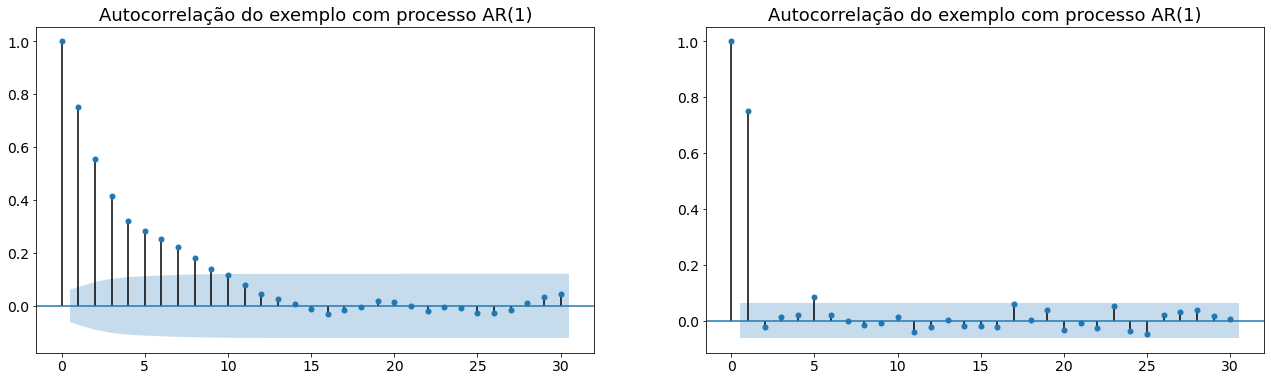

In [27]:
fig, axs = plt.subplots(1,2)
tsa.plot_acf(serie_ar1, ax = axs[0], title="Autocorrelação do exemplo com processo AR(1)")
_ = tsa.plot_pacf(serie_ar1, ax = axs[1], title="Autocorrelação do exemplo com processo AR(1)")

In [28]:
resultado_adf(adfuller(serie_ar2))

Statistics=-6.965, p-valor=0.00000000

**A série é estacionária (rejeitamos H0)**

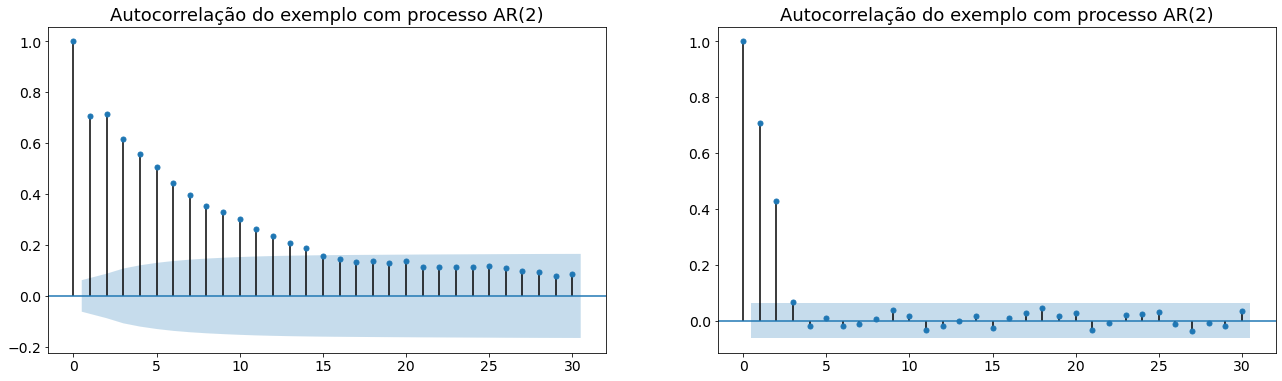

In [29]:
fig, axs = plt.subplots(1,2)
tsa.plot_acf(serie_ar2, ax = axs[0], title="Autocorrelação do exemplo com processo AR(2)")
_ = tsa.plot_pacf(serie_ar2, ax = axs[1], title="Autocorrelação do exemplo com processo AR(2)")

### Ajustamento

Ajustar um AR(p) envolve basicamente três passos:
1. O modelo e a sua ordem p precisam ser indentificados;
2. Os parâmetros do modelo $α_1, α_2, ..., α_p$ precisam ser estimados;
3. A qualidade do modelo ajustado precisam ser avaliados por uma análise dos resíduos $E_t$.

#### Ajustando o modelo AR(1)

In [30]:
m = serie_ar1.mean()
modelo_ar1 = sm.tsa.AutoReg(serie_ar1 - m, lags=1).fit()

In [31]:
print(modelo_ar1.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                 1000
Model:                     AutoReg(1)   Log Likelihood               -1374.307
Method:               Conditional MLE   S.D. of innovations              0.958
Date:                Tue, 14 Feb 2023   AIC                             -0.081
Time:                        00:35:33   BIC                             -0.066
Sample:                             1   HQIC                            -0.075
                                 1000                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0002      0.030     -0.006      0.995      -0.060       0.059
y.L1           0.7515      0.021     35.992      0.000       0.711       0.792
                                    Roots           

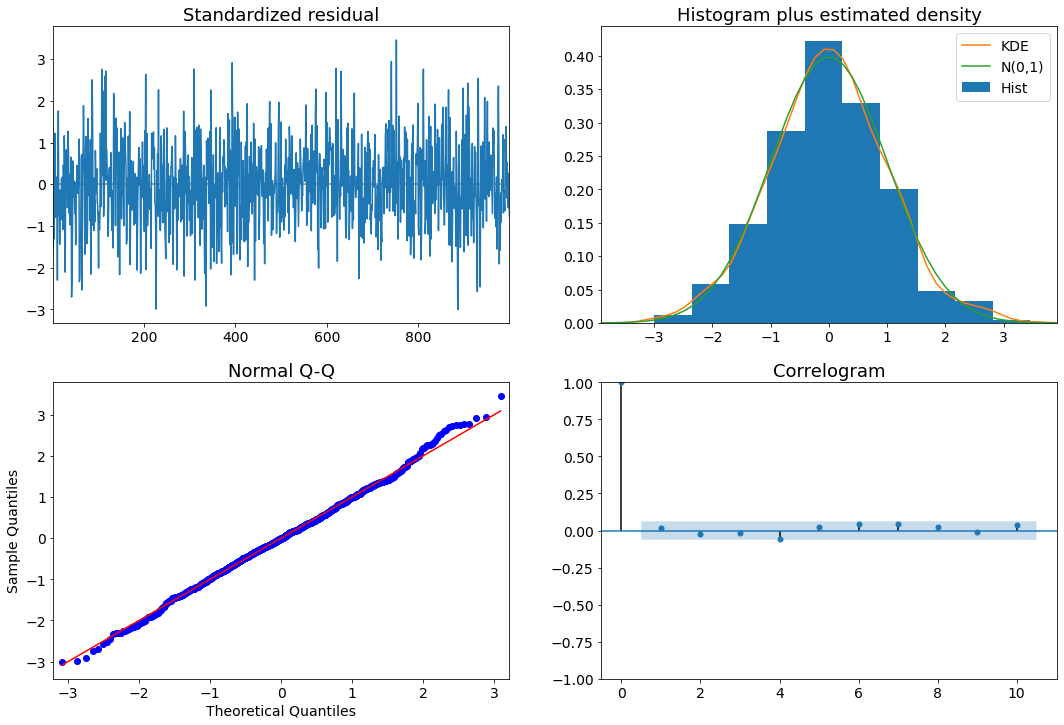

In [32]:
modelo_ar1.plot_diagnostics(figsize=(18,12));

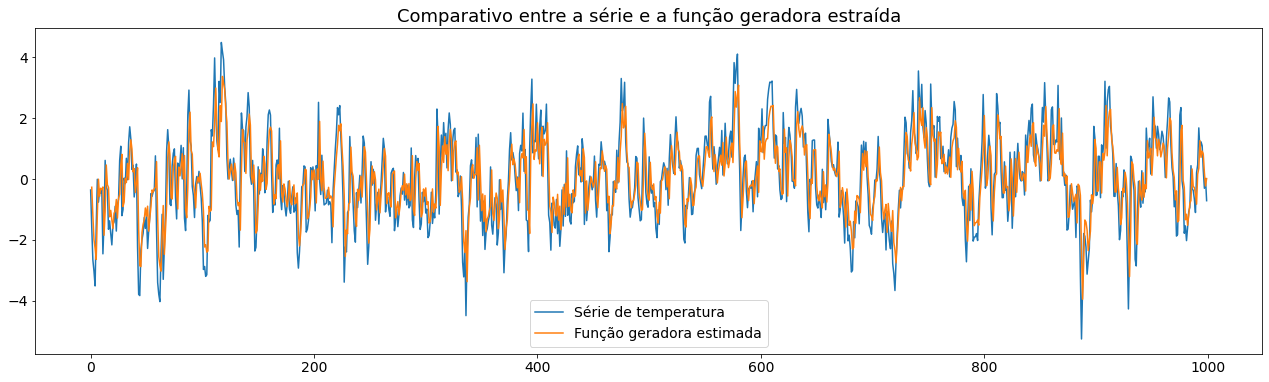

In [33]:
ax = (serie_ar1 - m).plot(title = "Comparativo entre a série e a função geradora estraída", label="Série de temperatura", legend= True)
_ = modelo_ar1.fittedvalues.plot(ax = ax, label="Função geradora estimada", legend= True)

#### Ajustando o modelo AR(2)

In [34]:
modelo_ar2 = sm.tsa.AutoReg(serie_ar2, lags=2).fit()

In [36]:
print(modelo_ar2.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                 1000
Model:                     AutoReg(2)   Log Likelihood               -1384.448
Method:               Conditional MLE   S.D. of innovations              0.969
Date:                Tue, 14 Feb 2023   AIC                             -0.055
Time:                        00:40:24   BIC                             -0.036
Sample:                             2   HQIC                            -0.048
                                 1000                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0400      0.031      1.285      0.199      -0.021       0.101
y.L1           0.4036      0.029     14.105      0.000       0.347       0.460
y.L2           0.4283      0.029     14.973      0.0

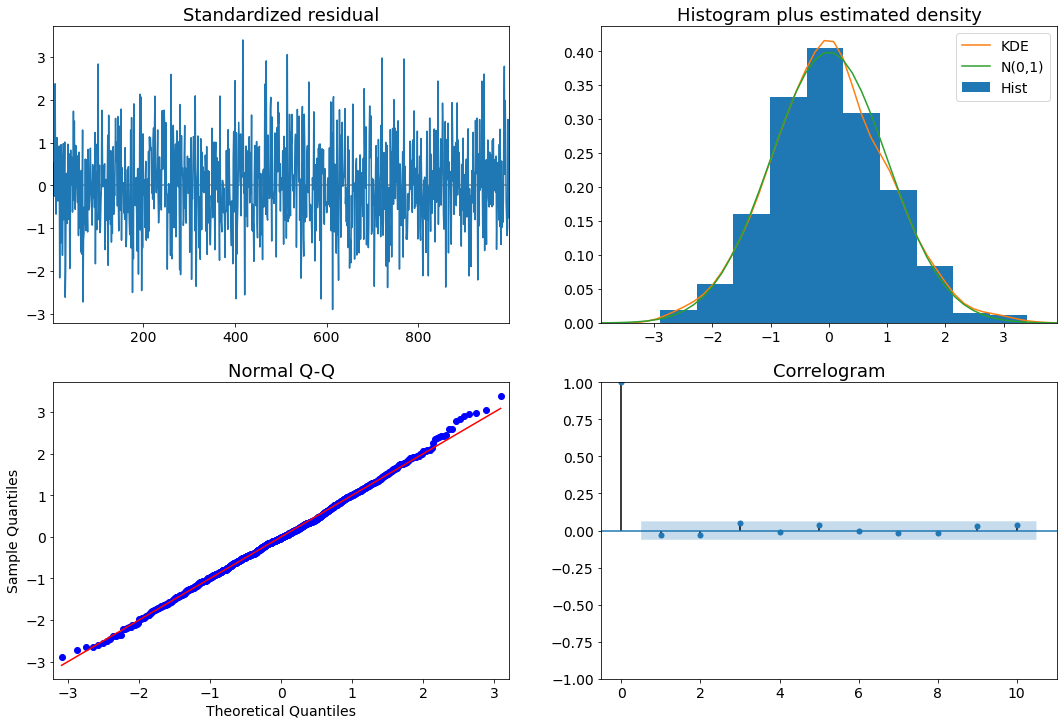

In [38]:
_ = modelo_ar2.plot_diagnostics(figsize=(18,12))

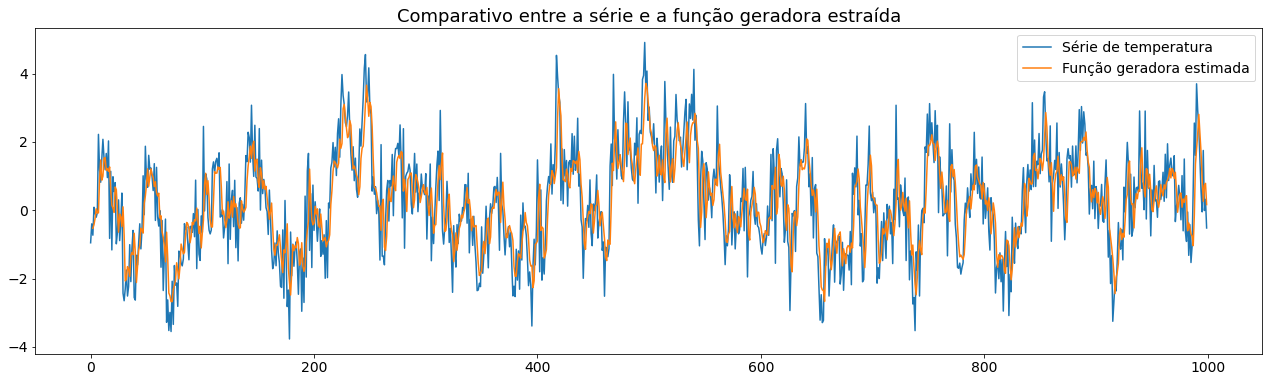

In [39]:
ax = serie_ar2.plot(title = "Comparativo entre a série e a função geradora estraída", label="Série de temperatura", legend= True)
_ = modelo_ar2.fittedvalues.plot(ax = ax, label="Função geradora estimada", legend= True)

Um bom modelo é aquele que os seus resíduos se assemelham ao ruído branco! Ou seja, os resíduos devem possuir:
- Média zero;
- Variância constante;
- Autocorrelação desprezível.

Se essas propriedades não estão presentes, o modelo não é adequado.

Para analisar os resíduos, devemos:

1. Calcular os Resíduos: $Y_{observado,t}-Y_{estimado,t} = E_t$
2. Calcular a Função de Autocorrelação (FAC) e a Função de Autocorrelação Parcial (PFAC) dos resíduos.

Sempre devemos verificar se os resíduos seguem uma distribuição normal, pois caso o contrário, pode haver espaço para aperfeiçoamento, como a aplicação de transformação de dados.

### Aplicações

Vamos aplicar na série de temperatura, tudo o que aprendemos. 


In [40]:
start = datetime(2018, 1, 1)
end = datetime(2022, 10, 31)

location = Point(-11.0056387, -37.2432436) #Aracaju

aracaju = Daily(location, start, end)
serie_aracaju = aracaju.fetch()

serie_aracaju.tavg.fillna(serie_aracaju.tavg.mean(),inplace=True)

In [41]:
y_aracaju = serie_aracaju.tavg - serie_aracaju.tavg.mean()
y_aracaju.dropna(inplace = True)

In [42]:
resultado_adf(adfuller(y_aracaju))

Statistics=-2.528, p-valor=0.10869437

**A série não é estacionária (falhamos em rejeitar H0)**

In [43]:
y_aracaju_dif = y_aracaju.diff()[1:]
resultado_adf(adfuller(y_aracaju_dif))

Statistics=-14.581, p-valor=0.00000000

**A série é estacionária (rejeitamos H0)**

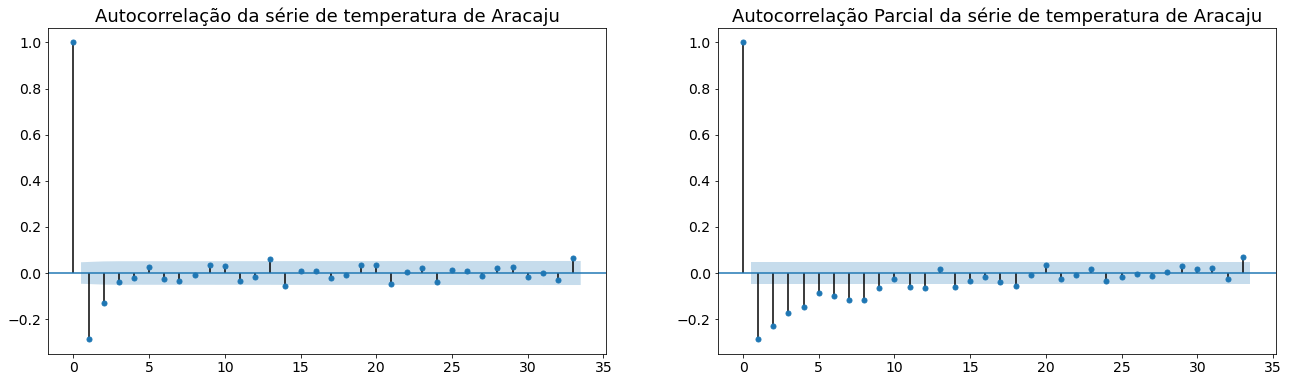

In [44]:
fig, axs = plt.subplots(1,2)
tsa.plot_acf(y_aracaju_dif, ax = axs[0], title="Autocorrelação da série de temperatura de Aracaju")
_ = tsa.plot_pacf(y_aracaju_dif, ax = axs[1], title="Autocorrelação Parcial da série de temperatura de Aracaju")

In [45]:
modelo_temperatura_ar = sm.tsa.AutoReg(y_aracaju_dif, lags=9).fit()

In [46]:
print(modelo_temperatura_ar.summary())

                            AutoReg Model Results                             
Dep. Variable:                   tavg   No. Observations:                 1764
Model:                     AutoReg(9)   Log Likelihood               -1739.769
Method:               Conditional MLE   S.D. of innovations              0.652
Date:                Tue, 14 Feb 2023   AIC                             -0.843
Time:                        00:45:37   BIC                             -0.808
Sample:                    01-11-2018   HQIC                            -0.830
                         - 10-31-2022                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0012      0.016     -0.077      0.938      -0.032       0.029
tavg.L1       -0.4716      0.024    -19.801      0.000      -0.518      -0.425
tavg.L2       -0.4157      0.026    -15.928      0.0

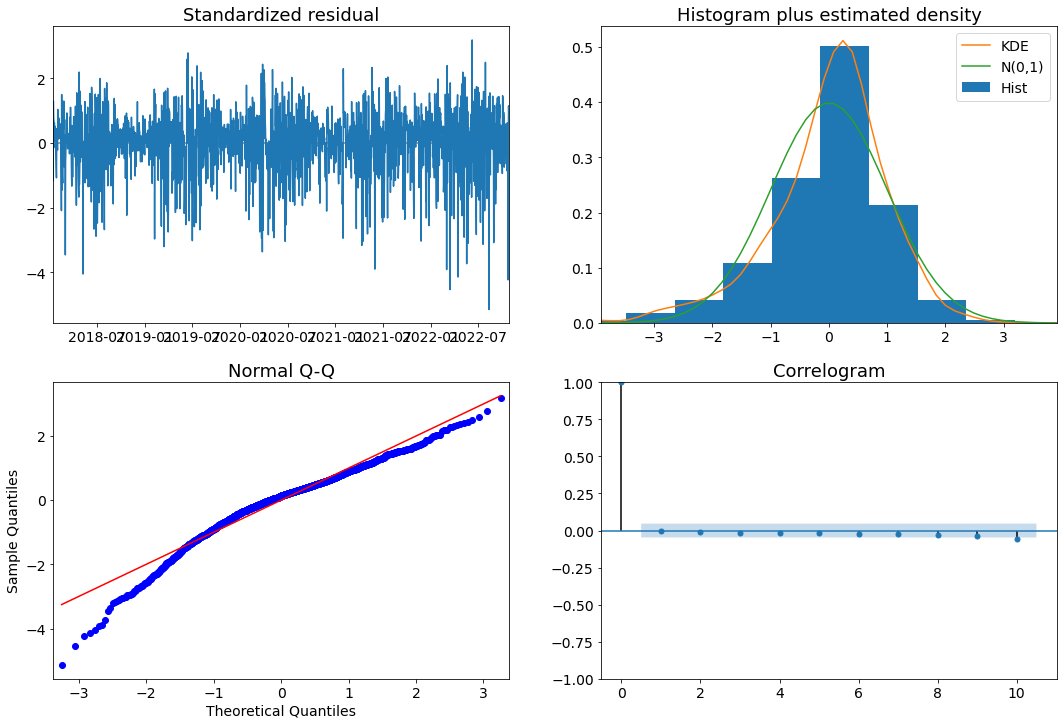

In [47]:
modelo_temperatura_ar.plot_diagnostics(figsize=(18,12));

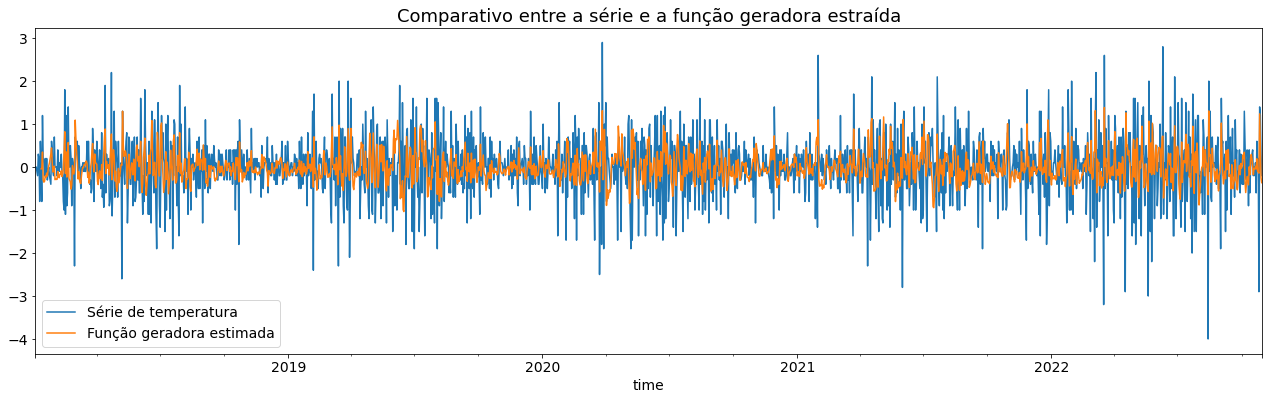

In [48]:
ax = y_aracaju_dif.plot(title = "Comparativo entre a série e a função geradora estraída", label="Série de temperatura", legend= True)
_ = modelo_temperatura_ar.fittedvalues.plot(ax = ax, label="Função geradora estimada", legend= True)

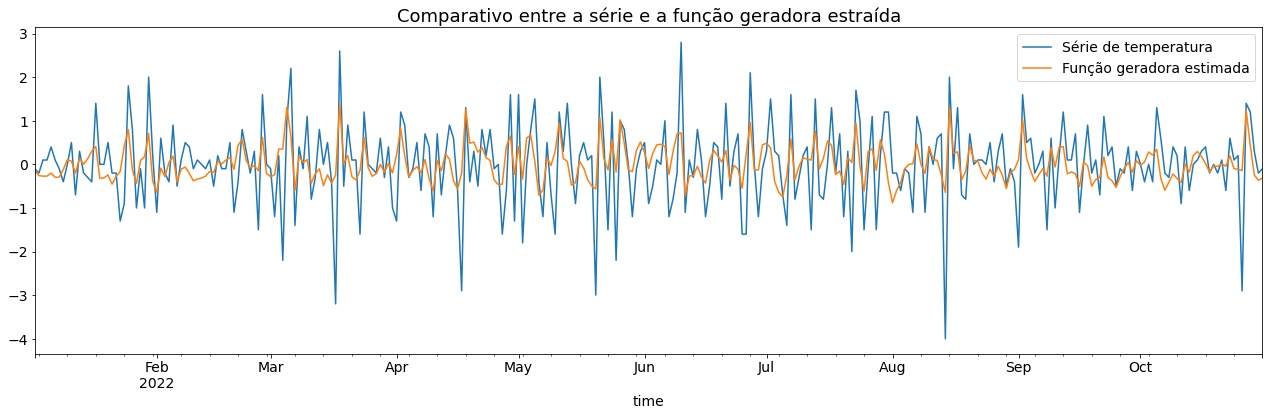

In [49]:
ax = y_aracaju_dif[y_aracaju_dif.index > "2022-01-01"].plot(title = "Comparativo entre a série e a função geradora estraída", label="Série de temperatura", legend= True)
_ = modelo_temperatura_ar.fittedvalues[modelo_temperatura_ar.fittedvalues.index > "2022-01-01"].plot(ax = ax, label="Função geradora estimada", legend= True)

## Exercício

1. Ajuste um modelo autoregressivo para a série de temperatura de sua cidade, realize a análise de resíduos e compare a série com o modelo. Não esquecer de:
  - Ajustar a média para 0
  - Tornar a série estacionária
  - Valida se a série é estacionária utilizando o teste de estacionariedade. 
2. Realize o mesmo procedimento para a série de câmbio dólar/real